In [188]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

MAX_EVALS = 30
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer



DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [189]:
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [190]:
def runthebenchmark(hyperparameters):
    os.chdir('/home/meghaagr/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config.py"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print(output)
    if len(output.split(" ")) > 5:
        value = output.split(" ")[5]
        value = float(value)
        print(value)
        return float(1/value)
    return 0;
    #logging.basicConfig(filename='app.log', filemode='a', format='%(name)s - %(levelname)s - %(message)s',level=logging.DEBUG)


In [191]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [192]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        result = runthebenchmark(hyperparameters)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [193]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,3,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [194]:
x = sample(space)
params = x
print(x)
cb_buffer_size_dist = []
for _ in range(30):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])

{'cb_buffer_size': 55574528.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 10.0, 'setstripe-size': 65536.0}


In [195]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

In [196]:
# File to save first results
print(os.getcwd())
out_file = '/home/meghaagr/project/progress/active/result/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()


/home/meghaagr/project/progress


In [197]:
from hyperopt import fmin


ITERATION = 0

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

  0%|          | 0/30 [00:00<?, ?it/s, best loss: ?]

INFO:hyperopt.tpe:tpe_transform took 0.009613 seconds
INFO:hyperopt.tpe:TPE using 0 trials


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '3145728'}, 'lfs': {'setstripe': {'size': 1048576, 'count': 3}}}
S3D-IO 50-100-100-2-2-4-1 104.23 0.06 0.59 224.32 0.30 1.36 0.05 0.02 1048576 3 disable disable enable enable 3145728 

224.32                                              
{'loss': 0.004457917261055635, 'hyperparameters': {'cb_buffer_size': 3145728.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 1048576.0}, 'iteration': 1, 'iteration_time': 6.191020569764078, 'status': 'ok'}
  3%|▎         | 1/30 [00:06<03:00,  6.22s/it, best loss: 0.004457917261055635]

INFO:hyperopt.tpe:tpe_transform took 0.010175 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.004458


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '246415360'}, 'lfs': {'setstripe': {'size': 524288, 'count': 14}}}
S3D-IO 50-100-100-2-2-4-1 435.40 0.06 0.14 112.72 0.30 2.71 0.07 0.02 524288 14 disable disable disable disable 246415360 

112.72                                                                         
{'loss': 0.008871540099361249, 'hyperparameters': {'cb_buffer_size': 246415360.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 524288.0}, 'iteration': 2, 'iteration_time': 6.909402400255203, 'status': 'ok'}
  7%|▋         | 2/30 [00:13<03:00,  6.44s/it, best loss: 0.004457917261055635]

INFO:hyperopt.tpe:tpe_transform took 0.009887 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.004458


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '296747008'}, 'lfs': {'setstripe': {'size': 655360, 'count': 8}}}
S3D-IO 50-100-100-2-2-4-1 334.96 0.06 0.18 224.73 0.30 1.36 0.07 0.02 655360 8 enable enable enable enable 296747008 

224.73                                                                         
{'loss': 0.004449784185467005, 'hyperparameters': {'cb_buffer_size': 296747008.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 655360.0}, 'iteration': 3, 'iteration_time': 5.505212417803705, 'status': 'ok'}
 10%|█         | 3/30 [00:18<02:46,  6.17s/it, best loss: 0.004449784185467005]

INFO:hyperopt.tpe:tpe_transform took 0.010489 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.004450


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '307232768'}, 'lfs': {'setstripe': {'size': 131072, 'count': 5}}}
S3D-IO 50-100-100-2-2-4-1 95.29 0.06 0.64 233.40 0.30 1.31 0.05 0.03 131072 5 disable enable enable disable 307232768 

233.4                                                                          
{'loss': 0.004284490145672665, 'hyperparameters': {'cb_buffer_size': 307232768.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 5.0, 'setstripe-size': 131072.0}, 'iteration': 4, 'iteration_time': 6.069656312465668, 'status': 'ok'}
 13%|█▎        | 4/30 [00:24<02:39,  6.15s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.009989 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '340787200'}, 'lfs': {'setstripe': {'size': 131072, 'count': 19}}}
S3D-IO 50-100-100-2-2-4-1 289.87 0.06 0.21 71.02 0.30 4.30 0.05 0.02 131072 19 enable enable disable disable 340787200 

71.02                                                                          
{'loss': 0.014080540692762603, 'hyperparameters': {'cb_buffer_size': 340787200.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 19.0, 'setstripe-size': 131072.0}, 'iteration': 5, 'iteration_time': 8.530249319039285, 'status': 'ok'}
 17%|█▋        | 5/30 [00:33<02:51,  6.87s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.006629 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '127926272'}, 'lfs': {'setstripe': {'size': 131072, 'count': 9}}}
S3D-IO 50-100-100-2-2-4-1 244.85 0.06 0.25 138.20 0.30 2.21 0.07 0.02 131072 9 disable enable disable enable 127926272 

138.2                                                                          
{'loss': 0.007235890014471781, 'hyperparameters': {'cb_buffer_size': 127926272.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 9.0, 'setstripe-size': 131072.0}, 'iteration': 6, 'iteration_time': 6.475348972715437, 'status': 'ok'}
 20%|██        | 6/30 [00:39<02:42,  6.76s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.014946 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '468713472'}, 'lfs': {'setstripe': {'size': 524288, 'count': 6}}}
S3D-IO 50-100-100-2-2-4-1 226.06 0.06 0.27 204.53 0.30 1.49 0.07 0.03 524288 6 enable enable enable disable 468713472 

204.53                                                                         
{'loss': 0.004889258299515964, 'hyperparameters': {'cb_buffer_size': 468713472.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 524288.0}, 'iteration': 7, 'iteration_time': 5.777005371637642, 'status': 'ok'}
 23%|██▎       | 7/30 [00:45<02:28,  6.48s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.013099 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '290455552'}, 'lfs': {'setstripe': {'size': 196608, 'count': 12}}}
S3D-IO 50-100-100-2-2-4-1 297.56 0.06 0.21 66.88 0.30 4.56 0.06 0.03 196608 12 enable enable enable disable 290455552 

66.88                                                                          
{'loss': 0.014952153110047849, 'hyperparameters': {'cb_buffer_size': 290455552.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 12.0, 'setstripe-size': 196608.0}, 'iteration': 8, 'iteration_time': 8.773635063320398, 'status': 'ok'}
 27%|██▋       | 8/30 [00:54<02:37,  7.18s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.010005 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '252706816'}, 'lfs': {'setstripe': {'size': 196608, 'count': 17}}}
S3D-IO 50-100-100-2-2-4-1 104.83 0.06 0.58 58.04 0.30 5.26 0.08 0.02 196608 17 enable enable disable enable 252706816 

58.04                                                                          
{'loss': 0.01722949689869056, 'hyperparameters': {'cb_buffer_size': 252706816.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 17.0, 'setstripe-size': 196608.0}, 'iteration': 9, 'iteration_time': 9.8386559644714, 'status': 'ok'}
 30%|███       | 9/30 [01:04<02:47,  7.98s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.010131 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '135266304'}, 'lfs': {'setstripe': {'size': 65536, 'count': 13}}}
S3D-IO 50-100-100-2-2-4-1 328.60 0.06 0.19 31.20 0.30 9.78 0.07 0.03 65536 13 enable disable enable disable 135266304 

31.2                                                                           
{'loss': 0.032051282051282055, 'hyperparameters': {'cb_buffer_size': 135266304.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 13.0, 'setstripe-size': 65536.0}, 'iteration': 10, 'iteration_time': 13.983238934539258, 'status': 'ok'}
 33%|███▎      | 10/30 [01:18<03:15,  9.79s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.010743 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '395313152'}, 'lfs': {'setstripe': {'size': 262144, 'count': 20}}}
S3D-IO 50-100-100-2-2-4-1 541.52 0.06 0.11 87.67 0.30 3.48 0.06 0.03 262144 20 disable disable disable enable 395313152 

87.67                                                                           
{'loss': 0.011406410402646287, 'hyperparameters': {'cb_buffer_size': 395313152.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 20.0, 'setstripe-size': 262144.0}, 'iteration': 11, 'iteration_time': 7.548892511986196, 'status': 'ok'}
 37%|███▋      | 11/30 [01:25<02:53,  9.13s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.013227 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '347078656'}, 'lfs': {'setstripe': {'size': 65536, 'count': 14}}}
S3D-IO 50-100-100-2-2-4-1 285.62 0.06 0.21 37.53 0.30 8.13 0.07 0.02 65536 14 enable enable disable disable 347078656 

37.53                                                                           
{'loss': 0.02664535038635758, 'hyperparameters': {'cb_buffer_size': 347078656.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 14.0, 'setstripe-size': 65536.0}, 'iteration': 12, 'iteration_time': 12.36706867814064, 'status': 'ok'}
 40%|████      | 12/30 [01:38<03:01, 10.11s/it, best loss: 0.004284490145672665]

INFO:hyperopt.tpe:tpe_transform took 0.010255 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.004284


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '521142272'}, 'lfs': {'setstripe': {'size': 65536, 'count': 0}}}
S3D-IO 50-100-100-2-2-4-1 373.88 0.06 0.16 348.51 0.30 0.88 0.12 0.05 65536 0 enable disable disable enable 521142272 

348.51                                                                          
{'loss': 0.0028693581245875298, 'hyperparameters': {'cb_buffer_size': 521142272.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 0.0, 'setstripe-size': 65536.0}, 'iteration': 13, 'iteration_time': 5.210991165600717, 'status': 'ok'}
 43%|████▎     | 13/30 [01:43<02:27,  8.65s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.010678 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '396361728'}, 'lfs': {'setstripe': {'size': 327680, 'count': 5}}}
S3D-IO 50-100-100-2-2-4-1 108.02 0.06 0.57 163.71 0.30 1.86 0.07 0.03 327680 5 disable enable enable enable 396361728 

163.71                                                                           
{'loss': 0.006108362348054486, 'hyperparameters': {'cb_buffer_size': 396361728.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 5.0, 'setstripe-size': 327680.0}, 'iteration': 14, 'iteration_time': 6.498173527419567, 'status': 'ok'}
 47%|████▋     | 14/30 [01:50<02:08,  8.02s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.014433 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '285212672'}, 'lfs': {'setstripe': {'size': 65536, 'count': 3}}}
S3D-IO 50-100-100-2-2-4-1 320.29 0.06 0.19 306.32 0.30 1.00 0.06 0.02 65536 3 enable disable enable disable 285212672 

306.32                                                                           
{'loss': 0.0032645599373204493, 'hyperparameters': {'cb_buffer_size': 285212672.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 65536.0}, 'iteration': 15, 'iteration_time': 5.235235403291881, 'status': 'ok'}
 50%|█████     | 15/30 [01:55<01:47,  7.19s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.009858 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '530579456'}, 'lfs': {'setstripe': {'size': 720896, 'count': 16}}}
S3D-IO 50-100-100-2-2-4-1 401.19 0.06 0.15 132.55 0.30 2.30 0.06 0.02 720896 16 enable disable enable enable 530579456 

132.55                                                                           
{'loss': 0.007544322897019992, 'hyperparameters': {'cb_buffer_size': 530579456.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 16.0, 'setstripe-size': 720896.0}, 'iteration': 16, 'iteration_time': 6.507812900468707, 'status': 'ok'}
 53%|█████▎    | 16/30 [02:01<01:37,  7.00s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.010231 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '469762048'}, 'lfs': {'setstripe': {'size': 393216, 'count': 4}}}
S3D-IO 50-100-100-2-2-4-1 244.41 0.06 0.25 253.07 0.30 1.21 0.06 0.03 393216 4 enable disable enable disable 469762048 

253.07                                                                           
{'loss': 0.0039514758762397755, 'hyperparameters': {'cb_buffer_size': 469762048.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 4.0, 'setstripe-size': 393216.0}, 'iteration': 17, 'iteration_time': 5.462051587179303, 'status': 'ok'}
 57%|█████▋    | 17/30 [02:07<01:25,  6.54s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.009998 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '213909504'}, 'lfs': {'setstripe': {'size': 786432, 'count': 4}}}
S3D-IO 50-100-100-2-2-4-1 301.21 0.06 0.20 304.54 0.30 1.00 0.07 0.02 786432 4 enable enable disable enable 213909504 

304.54                                                                           
{'loss': 0.003283640901031063, 'hyperparameters': {'cb_buffer_size': 213909504.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 786432.0}, 'iteration': 18, 'iteration_time': 5.227029758505523, 'status': 'ok'}
 60%|██████    | 18/30 [02:12<01:13,  6.16s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.005180 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '47185920'}, 'lfs': {'setstripe': {'size': 131072, 'count': 6}}}
S3D-IO 50-100-100-2-2-4-1 185.90 0.06 0.33 94.06 0.30 3.24 0.05 0.02 131072 6 disable disable enable enable 47185920 

94.06                                                                            
{'loss': 0.0106315118009781, 'hyperparameters': {'cb_buffer_size': 47185920.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 6.0, 'setstripe-size': 131072.0}, 'iteration': 19, 'iteration_time': 7.576150564476848, 'status': 'ok'}
 63%|██████▎   | 19/30 [02:20<01:12,  6.59s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.010121 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '264241152'}, 'lfs': {'setstripe': {'size': 131072, 'count': 9}}}
S3D-IO 50-100-100-2-2-4-1 270.05 0.06 0.23 195.87 0.30 1.56 0.05 0.03 131072 9 enable enable disable enable 264241152 

195.87                                                                           
{'loss': 0.005105427068974319, 'hyperparameters': {'cb_buffer_size': 264241152.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 9.0, 'setstripe-size': 131072.0}, 'iteration': 20, 'iteration_time': 5.701894709840417, 'status': 'ok'}
 67%|██████▋   | 20/30 [02:26<01:03,  6.33s/it, best loss: 0.0028693581245875298]

INFO:hyperopt.tpe:tpe_transform took 0.005147 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.002869


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '519045120'}, 'lfs': {'setstripe': {'size': 65536, 'count': 0}}}
S3D-IO 50-100-100-2-2-4-1 285.59 0.06 0.21 368.11 0.30 0.83 0.11 0.04 65536 0 enable disable disable disable 519045120 

368.11                                                                           
{'loss': 0.002716579283366385, 'hyperparameters': {'cb_buffer_size': 519045120.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 0.0, 'setstripe-size': 65536.0}, 'iteration': 21, 'iteration_time': 5.134054715745151, 'status': 'ok'}
 70%|███████   | 21/30 [02:31<00:53,  5.98s/it, best loss: 0.002716579283366385] 

INFO:hyperopt.tpe:tpe_transform took 0.005334 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.002717


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '532676608'}, 'lfs': {'setstripe': {'size': 65536, 'count': 1}}}
S3D-IO 50-100-100-2-2-4-1                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '532676608'}, 'lfs': {'setstripe': {'size': 65536, 'count': 1}}}
S3D-IO 50-100-100-2-2-4-1 623.82 0.06 0.10 364.22 0.30 0.84 0.09 0.02 65536 1 enable disable disable disable 532676608 

364.22                                                                          
{'loss': 0.002745593322717039, 'hyperparameters': {'cb_buffer_size': 532676608.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 65536.0}, 'iteration': 22, 'iteration_time': 9.994188911281526, 'statu

INFO:hyperopt.tpe:tpe_transform took 0.010020 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.002717


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '473956352'}, 'lfs': {'setstripe': {'size': 65536, 'count': 0}}}
S3D-IO 50-100-100-2-2-4-1 576.50 0.06 0.11 363.61 0.30 0.84 0.09 0.04 65536 0 enable disable disable disable 473956352 

363.61                                                                          
{'loss': 0.0027501993894557355, 'hyperparameters': {'cb_buffer_size': 473956352.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 0.0, 'setstripe-size': 65536.0}, 'iteration': 23, 'iteration_time': 4.955963845364749, 'status': 'ok'}
 77%|███████▋  | 23/30 [02:46<00:45,  6.55s/it, best loss: 0.002716579283366385]

INFO:hyperopt.tpe:tpe_transform took 0.009940 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.002717


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '422576128'}, 'lfs': {'setstripe': {'size': 65536, 'count': 1}}}
S3D-IO 50-100-100-2-2-4-1 534.14 0.06 0.11 365.64 0.30 0.83 0.08 0.02 65536 1 enable disable disable disable 422576128 

365.64                                                                          
{'loss': 0.002734930532764468, 'hyperparameters': {'cb_buffer_size': 422576128.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 65536.0}, 'iteration': 24, 'iteration_time': 4.857151509262621, 'status': 'ok'}
 80%|████████  | 24/30 [02:51<00:36,  6.06s/it, best loss: 0.002716579283366385]

INFO:hyperopt.tpe:tpe_transform took 0.005203 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.002717


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '423624704'}, 'lfs': {'setstripe': {'size': 65536, 'count': 2}}}
S3D-IO 50-100-100-2-2-4-1 571.48 0.06 0.11 362.77 0.30 0.84 0.07 0.02 65536 2 enable disable disable disable 423624704 

362.77                                                                          
{'loss': 0.0027565675221214547, 'hyperparameters': {'cb_buffer_size': 423624704.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 65536.0}, 'iteration': 25, 'iteration_time': 5.019745420664549, 'status': 'ok'}
 83%|████████▎ | 25/30 [02:56<00:28,  5.76s/it, best loss: 0.002716579283366385]

INFO:hyperopt.tpe:tpe_transform took 0.009921 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.002717


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '420478976'}, 'lfs': {'setstripe': {'size': 196608, 'count': 2}}}
S3D-IO 50-100-100-2-2-4-1 254.11 0.06 0.24 393.48 0.30 0.78 0.06 0.02 196608 2 enable disable disable disable 420478976 

393.48                                                                          
{'loss': 0.002541425231269696, 'hyperparameters': {'cb_buffer_size': 420478976.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 196608.0}, 'iteration': 26, 'iteration_time': 4.973735558800399, 'status': 'ok'}
 87%|████████▋ | 26/30 [03:01<00:22,  5.55s/it, best loss: 0.002541425231269696]

INFO:hyperopt.tpe:tpe_transform took 0.012655 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.002541


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '491782144'}, 'lfs': {'setstripe': {'size': 196608, 'count': 7}}}
S3D-IO 50-100-100-2-2-4-1 101.61 0.06 0.60 195.92 0.30 1.56 0.08 0.02 196608 7 enable disable disable disable 491782144 

195.92                                                                          
{'loss': 0.005104124132298898, 'hyperparameters': {'cb_buffer_size': 491782144.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 7.0, 'setstripe-size': 196608.0}, 'iteration': 27, 'iteration_time': 6.145184705033898, 'status': 'ok'}
 90%|█████████ | 27/30 [03:07<00:17,  5.75s/it, best loss: 0.002541425231269696]

INFO:hyperopt.tpe:tpe_transform took 0.009930 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.002541


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '351272960'}, 'lfs': {'setstripe': {'size': 262144, 'count': 11}}}
S3D-IO 50-100-100-2-2-4-1 376.77 0.06 0.16 180.28 0.30 1.69 0.07 0.03 262144 11 enable disable disable disable 351272960 

180.28                                                                          
{'loss': 0.005546927002440648, 'hyperparameters': {'cb_buffer_size': 351272960.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 262144.0}, 'iteration': 28, 'iteration_time': 5.781206252984703, 'status': 'ok'}
 93%|█████████▎| 28/30 [03:13<00:11,  5.78s/it, best loss: 0.002541425231269696]

INFO:hyperopt.tpe:tpe_transform took 0.009912 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.002541


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '439353344'}, 'lfs': {'setstripe': {'size': 983040, 'count': 2}}}
S3D-IO 50-100-100-2-2-4-1 244.52 0.06 0.25 240.05 0.30 1.27 0.06 0.03 983040 2 enable disable disable disable 439353344 

240.05                                                                          
{'loss': 0.00416579879191835, 'hyperparameters': {'cb_buffer_size': 439353344.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 983040.0}, 'iteration': 29, 'iteration_time': 5.542620090767741, 'status': 'ok'}
 97%|█████████▋| 29/30 [03:18<00:05,  5.73s/it, best loss: 0.002541425231269696]

INFO:hyperopt.tpe:tpe_transform took 0.009818 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.002541


{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '382730240'}, 'lfs': {'setstripe': {'size': 1245184, 'count': 0}}}
S3D-IO 50-100-100-2-2-4-1 424.62 0.06 0.14 365.72 0.30 0.83 0.09 0.02 1245184 0 enable disable disable disable 382730240 

365.72                                                                          
{'loss': 0.002734332276058186, 'hyperparameters': {'cb_buffer_size': 382730240.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 0.0, 'setstripe-size': 1245184.0}, 'iteration': 30, 'iteration_time': 4.943730584345758, 'status': 'ok'}
100%|██████████| 30/30 [03:23<00:00,  5.52s/it, best loss: 0.002541425231269696]


In [198]:
print(best)
d=  best
print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1]

{'cb_buffer_size': 401.0, 'romio_cb_read': 1, 'romio_cb_write': 1, 'romio_ds_read': 0, 'romio_ds_write': 1, 'setstripe-count': 2.0, 'setstripe-size': 3.0}
[{'loss': 0.004457917261055635, 'hyperparameters': {'cb_buffer_size': 3145728.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 1048576.0}, 'iteration': 1, 'iteration_time': 6.191020569764078, 'status': 'ok'}, {'loss': 0.008871540099361249, 'hyperparameters': {'cb_buffer_size': 246415360.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 524288.0}, 'iteration': 2, 'iteration_time': 6.909402400255203, 'status': 'ok'}, {'loss': 0.004449784185467005, 'hyperparameters': {'cb_buffer_size': 296747008.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count

[{'loss': 0.002541425231269696,
  'hyperparameters': {'cb_buffer_size': 420478976.0,
   'romio_cb_read': 'disable',
   'romio_cb_write': 'disable',
   'romio_ds_read': 'enable',
   'romio_ds_write': 'disable',
   'setstripe-count': 2.0,
   'setstripe-size': 196608.0},
  'iteration': 26,
  'iteration_time': 4.973735558800399,
  'status': 'ok'}]

In [199]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time
0,0.002735,"{'cb_buffer_size': 422576128.0, 'romio_cb_read...",24,4.857152
1,0.002734,"{'cb_buffer_size': 382730240.0, 'romio_cb_read...",30,4.943731
2,0.002750,"{'cb_buffer_size': 473956352.0, 'romio_cb_read...",23,4.955964
3,0.002541,"{'cb_buffer_size': 420478976.0, 'romio_cb_read...",26,4.973736
4,0.002757,"{'cb_buffer_size': 423624704.0, 'romio_cb_read...",25,5.019745


In [200]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)

{'cb_buffer_size': 422576128.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 65536.0}


In [201]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration
0,4.22576e+08,disable,disable,enable,disable,1,65536,4.857152,0.002735,24
1,3.8273e+08,disable,disable,enable,disable,0,1.24518e+06,4.943731,0.002734,30
2,4.73956e+08,disable,disable,enable,disable,0,65536,4.955964,0.002750,23
3,4.20479e+08,disable,disable,enable,disable,2,196608,4.973736,0.002541,26
4,4.23625e+08,disable,disable,enable,disable,2,65536,5.019745,0.002757,25


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


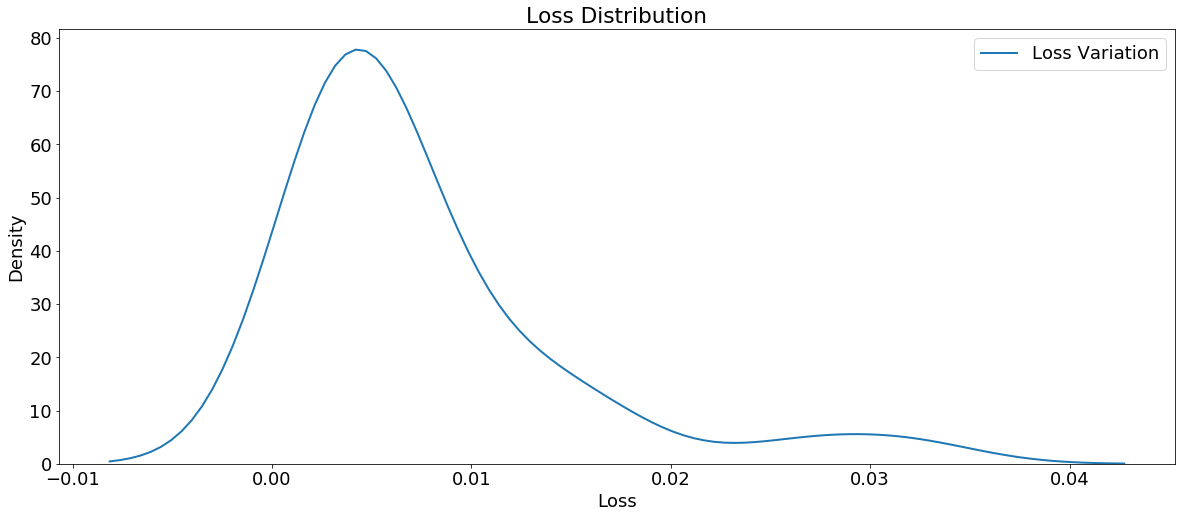

In [202]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


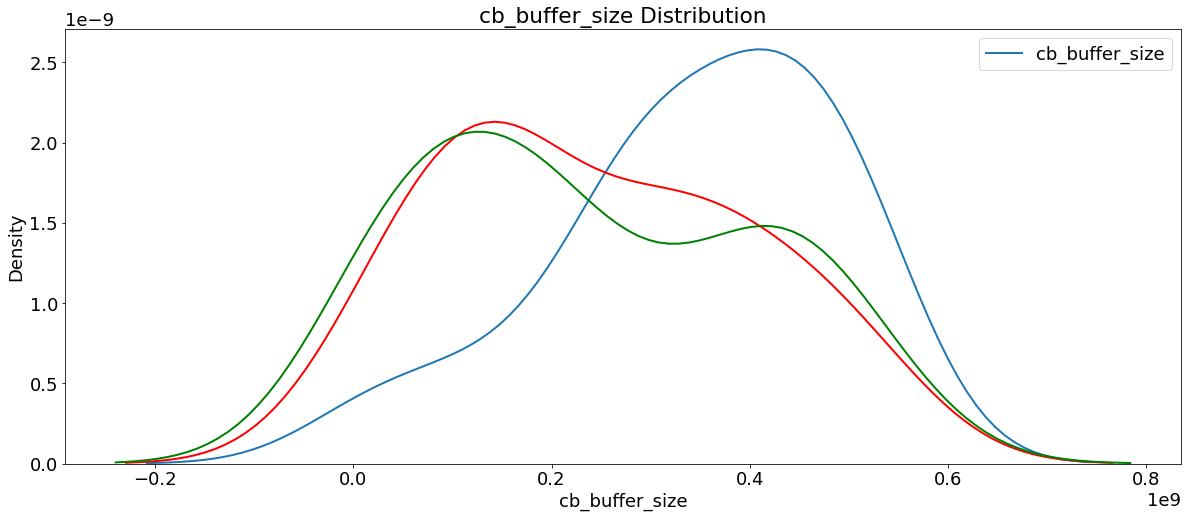

In [203]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
cb_buffer_size_dist_now = []
for _ in range(30):
    cb_buffer_size_dist_now.append(sample(space)['cb_buffer_size'])
# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['cb_buffer_size'], label = 'cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2)
sns.kdeplot(cb_buffer_size_dist_now,color="green",linewidth=2)
plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');


In [204]:
import random
import numpy as np

def random_objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result = runthebenchmark(hyperparameters)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time])
    return [ float(result), hyperparameters, ITERATION, run_time]


In [205]:

random_space = {
    'romio_ds_read' : ['enable','disable'],
    'romio_ds_write' : ['enable','disable'],
    'romio_cb_read' : ['enable','disable'],
    'romio_cb_write' : ['enable','disable'],
    'cb_buffer_size' : [1048576*x for x in list(range(0,1024,4))],
    'setstripe-size' : [65536*x for x in list(range(0,3,1))],
    'setstripe-count' : list(range(0,20,1))
    
}
random.seed(50)

random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'time'],
                       index = list(range(MAX_EVALS)))

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in random_space.items()}
    print(params)
    results_list = random_objective(params)
    random_results.loc[i, :] = results_list


{'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': 1015021568, 'setstripe-size': 65536, 'setstripe-count': 2}
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '1015021568'}, 'lfs': {'setstripe': {'size': 65536, 'count': 2}}}
S3D-IO 50-100-100-2-2-4-1 107.57 0.06 0.57 378.49 0.30 0.81 0.07 0.02 65536 2 disable disable disable enable 1015021568 

378.49
{'loss': 0.0026420777299268144, 'hyperparameters': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': 1015021568, 'setstripe-size': 65536, 'setstripe-count': 2}, 'iteration': 31, 'iteration_time': 5.610302967019379, 'status': 'ok'}
{'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': 742391808, 'setstripe-size': 0,

S3D-IO 50-100-100-2-2-4-1 487.12 0.06 0.13 401.02 0.30 0.76 0.06 0.02 65536 2 disable disable disable disable 838860800 

401.02
{'loss': 0.002493641214902, 'hyperparameters': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': 838860800, 'setstripe-size': 65536, 'setstripe-count': 2}, 'iteration': 41, 'iteration_time': 4.922965033911169, 'status': 'ok'}
{'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': 37748736, 'setstripe-size': 0, 'setstripe-count': 14}
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '37748736'}, 'lfs': {'setstripe': {'size': 0, 'count': 14}}}
S3D-IO 50-100-100-2-2-4-1 317.72 0.06 0.19 364.82 0.30 0.84 0.06 0.02 0 14 disable enable disable enable 37748736 

364.82
{'loss': 0.002741077791787731, 'hyperparameters': {'ro

S3D-IO 50-100-100-2-2-4-1 106.48 0.06 0.58 58.60 0.30 5.21 0.06 0.03 131072 19 disable disable disable disable 629145600 

58.6
{'loss': 0.017064846416382253, 'hyperparameters': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': 629145600, 'setstripe-size': 131072, 'setstripe-count': 19}, 'iteration': 51, 'iteration_time': 9.805003799498081, 'status': 'ok'}
{'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': 532676608, 'setstripe-size': 65536, 'setstripe-count': 7}
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '532676608'}, 'lfs': {'setstripe': {'size': 65536, 'count': 7}}}
S3D-IO 50-100-100-2-2-4-1 290.68 0.06 0.21 69.48 0.30 4.39 0.07 0.02 65536 7 enable disable enable enable 532676608 

69.48
{'loss': 0.014392630972941852, 'hyperparame

In [133]:
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()


,loss,params,iteration,time
0,0.00252532,"{'romio_ds_read': 'disable', 'romio_ds_write':...",24,5.28523
1,0.00259902,"{'romio_ds_read': 'disable', 'romio_ds_write':...",50,4.96524
2,0.0026094,"{'romio_ds_read': 'enable', 'romio_ds_write': ...",53,5.65222
3,0.0026275,"{'romio_ds_read': 'disable', 'romio_ds_write':...",34,5.04684
4,0.00268991,"{'romio_ds_read': 'disable', 'romio_ds_write':...",35,5.13629


In [164]:
best_random_params = random_results.loc[0, 'params'].copy()
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
random_results = random_results[:20]
print(len(random_results))
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params['time'] = random_results['time']

random_params.head()

20


,romio_ds_read,romio_ds_write,romio_cb_read,romio_cb_write,cb_buffer_size,setstripe-size,setstripe-count,loss,iteration,time
0,disable,disable,disable,enable,1015021568,65536,2,0.00252532,24,5.28523
1,disable,disable,disable,enable,461373440,0,11,0.00259902,50,4.96524
2,enable,enable,enable,disable,868220928,131072,0,0.0026094,53,5.65222
3,disable,disable,disable,disable,838860800,65536,2,0.0026275,34,5.04684
4,disable,enable,disable,enable,37748736,0,14,0.00268991,35,5.13629


ValueError: color kwarg must have one color per data set. 20 data sets and 1 colors were provided

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


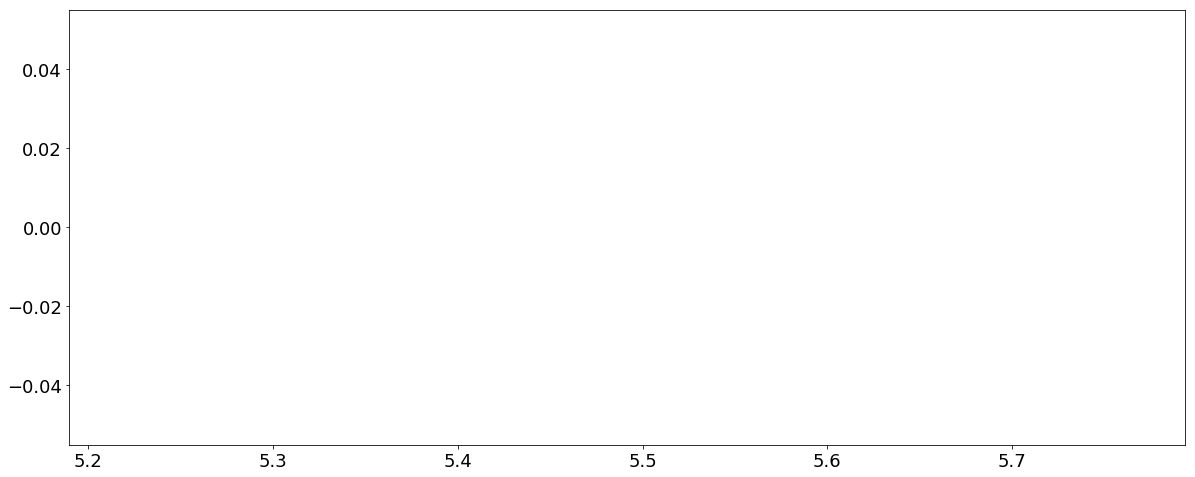

In [177]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.distplot(random_params['time'], label = 'Random Search')#, linewidth = 2)
#sns.distplot(bayes_params['train_time'], label = 'Bayes Optimization')#, linewidth = 2
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');